# Data (.mat files) loading processing

The Idea is to load the data from the .mat files and convert them into a pandas dataframe. The data is then saved as a pickle file for further use.

Besides this conversion, we have to process the raw subject-specific EEG data and separate it to the domains (classes).


In [2]:
%pip install seaborn

     |████████████████████████████████| 292 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import the neccesary libraries to read mat files
import scipy.io as sio
from scipy import signal
from scipy.signal import butter, lfilter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
import glob
import re
import pickle

import time
import datetime
import math
import random
import warnings

from os import listdir, makedirs

import importlib

from core.utils2 import fbcca, generate_ref_signal
warnings.filterwarnings('ignore')

## Description of the dataset:


This dataset gathered SSVEP-BCI recordings of 35 healthy subjects (17 females, aged 17-34 years, mean age: 22 years) focusing on 40 characters flickering at different frequencies (8-15.8 Hz with an interval of 0.2 Hz). For each subject, the experiment consisted of 6 blocks. Each block contained 40 trials corresponding to all 40 characters indicated in a random order. Each trial started with a visual cue (a red square) indicating a target stimulus. The cue appeared for 0.5 s on the screen. Subjects were asked to shift their gaze to the target as soon as possible within the cue duration. Following the cue offset, all stimuli started to flicker on the screen concurrently and lasted 5 s. After stimulus offset, the screen was blank for 0.5 s before the next trial began, which allowed the subjects to have short breaks between consecutive trials. Each trial lasted a total of 6 s. To facilitate visual fixation, a red triangle appeared below the flickering target during the stimulation period. In each block, subjects were asked to avoid eye blinks during the stimulation period. To avoid visual fatigue, there was a rest for several minutes between two consecutive blocks.

EEG data were acquired using a Synamps2 system (Neuroscan, Inc.) with a sampling rate of 1000 Hz. The amplifier frequency passband ranged from 0.15 Hz to 200 Hz. Sixty-four channels covered the whole scalp of the subject and were aligned according to the international 10-20 system. The ground was placed on midway between Fz and FPz. The reference was located on the vertex. Electrode impedances were kept below 10 KΩ. To remove the common power-line noise, a notch filter at 50 Hz was applied in data recording. Event triggers generated by the computer to the amplifier and recorded on an event channel synchronized to the EEG data. 


The continuous EEG data was segmented into 6 s epochs (500 ms pre-stimulus, 5.5 s post-stimulus onset). The epochs were subsequently downsampled to 250 Hz. Thus each trial consisted of 1250 time points. Finally, these data were stored as double-precision floating-point values in MATLAB and were named as subject indices (i.e., S01.mat, …, S35.mat). For each file, the data loaded in MATLAB generate a 4-D matrix named ‘data’ with dimensions of [64, 1250, 40, 6]. The four dimensions indicate ‘Electrode index’, ‘Time points’, ‘Target index’, and ‘Block index’. The electrode positions were saved in a ‘64-channels.loc’ file. Six trials were available for each SSVEP frequency. Frequency and phase values for the 40 target indices were saved in a ‘Freq_Phase.mat’ file.


+ Each trial lasted a total of 6 s.

+ Each trial consisted of 1250 time points.

+ There were 6 blocks. Thus, 6 trials for each SSVEP frequency. (9000 time points for each SSVEP frequency)

+ The total time for each SSVEP frequency was 6*6 = 36 s.

The frequency and phase values are used to generate the SSVEP stimuli. The stimuli are generated by the following equation:

$$
x(t) = sin(2\pi f t + \phi)
$$

where $f$ is the frequency and $\phi$ is the phase value.


In [23]:
# Path: core\utils.py
# read a mat file and return the data
def read_mat_file(file_path):
    data = sio.loadmat(file_path)
    return data


def read_mat_file_as_df(file_path, columns):
    data = read_mat_file(file_path)
    data_values = data['data']
    # shape --> (64, 1500, 40, 6)
    data_values = data_values[:, 125:(1250 + 125), :, :]
    data_values = data_values.reshape((64, 1250*40*6), order='F')
    data_labels = np.tile(np.arange(0, 40), 6).repeat(1250)
    data_values = data_values.swapaxes(0, 1)
    data_df = pd.DataFrame(data_values)
    data_df.columns = ["FP1", "FPZ", "FP2", "AF3", "AF4", "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "M1", "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8", "M2", "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "CB1"
                       , "O1", "Oz", "O2", "CB2"]
    data_df['labels'] = data_labels

    if columns is not None:
        data_df = data_df[columns + ['labels']]
    return data_df



In [26]:
read_mat_file("data/raw/Freq_Phase.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 10 15:31:46 2016',
 '__version__': '1.0',
 '__globals__': [],
 'phases': array([[0.        , 1.57079633, 3.14159265, 4.71238898, 0.        ,
         1.57079633, 3.14159265, 4.71238898, 1.57079633, 3.14159265,
         4.71238898, 0.        , 1.57079633, 3.14159265, 4.71238898,
         0.        , 3.14159265, 4.71238898, 0.        , 1.57079633,
         3.14159265, 4.71238898, 0.        , 1.57079633, 4.71238898,
         0.        , 1.57079633, 3.14159265, 4.71238898, 0.        ,
         1.57079633, 3.14159265, 0.        , 1.57079633, 3.14159265,
         4.71238898, 0.        , 1.57079633, 3.14159265, 4.71238898]]),
 'freqs': array([[ 8. ,  9. , 10. , 11. , 12. , 13. , 14. , 15. ,  8.2,  9.2, 10.2,
         11.2, 12.2, 13.2, 14.2, 15.2,  8.4,  9.4, 10.4, 11.4, 12.4, 13.4,
         14.4, 15.4,  8.6,  9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6,  8.8,
          9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8]])}

(64, 1500, 40, 6)
(3, 1250, 6)
(1250,)


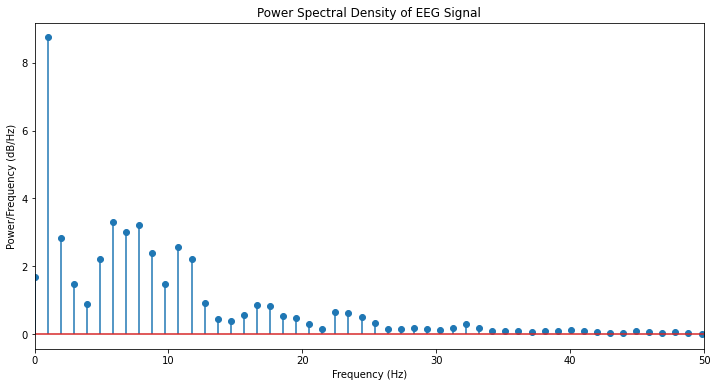

In [82]:
# Test the function with the path ".\data\raw\S3.mat"
data = read_mat_file("./data/raw/S5.mat")
print(data['data'].shape)
sample = data['data'][-4:-1, 125:(1250 + 125), 0]
print(sample.shape) # (3, 1250, 6) --> 3 electrodes, 1250 time steps, 6 trials
# flatten the sample for each channel/electrode
# sample = sample.reshape((3, -1))
sample = sample[0, :, 0]
print(sample.shape)
# Plot the power spectral density of the sample
# Detrend the signal
detrended_sample = signal.detrend(sample)

# Calculate the PSD of the detrended signal
freqs, psd = signal.welch(detrended_sample, fs=250)
# set all negatives to 0
plt.figure(figsize=(12, 6))
plt.stem(freqs, psd, use_line_collection=True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density of EEG Signal')
plt.xlim(0, 50)
plt.show()


In [5]:
read_mat_file_as_df("./data/raw/S5.mat", None).head()

,FP1,FPZ,FP2,AF3,AF4,F7,F5,F3,F1,FZ,...,POz,PO4,PO6,PO8,CB1,O1,Oz,O2,CB2,labels
0,10.108918,-14.112215,-20.736782,10.410501,-17.486549,63.642937,38.634930,10.110846,3.744565,-7.796495,...,-7.182360,-2.750710,5.512985,7.575869,3.998553,2.181352,2.805273,2.044350,2.051467,0
1,11.660419,-7.723398,-10.878441,22.554131,-10.483746,65.419365,52.768349,15.326104,3.142292,-5.648949,...,-6.667121,-2.977712,7.400465,8.483432,-2.620084,-2.190545,2.354680,3.529129,2.251929,0
2,16.909334,-8.234486,-8.943366,25.834463,-9.637864,64.499641,50.159237,17.716221,8.963383,-2.268387,...,-6.760086,0.233970,9.122921,11.665460,-1.189128,-0.744613,3.894319,3.982391,3.193593,0
3,16.408478,-8.046924,-12.777931,11.804686,-9.961390,68.730385,42.156200,20.231627,6.184649,-3.872819,...,-3.651304,-4.130810,3.856806,4.064088,0.695981,2.023296,4.518388,2.688585,1.717266,0
4,18.212481,-19.235991,-24.713688,4.648717,-19.493980,58.821926,33.926311,5.165588,-0.792949,-10.059841,...,-5.070547,-4.591337,1.193427,1.933741,-3.928124,-1.539490,1.225009,-0.994597,-1.553279,0


In [33]:
os.makedirs("./data/processed", exist_ok=True)

def read_all_mat_files_and_save_as_csv(columns=None, labels = None):
    for i in range(1, 36):
        file_path = "./data/raw/S" + str(i) + ".mat"
        data_df = read_mat_file_as_df(file_path, columns)

        if labels is not None:
            # Return only the data with a label in the labels list
            data_df = data_df[data_df['labels'].isin(labels)]
            
        data_df.to_csv("./data/processed/S" + str(i) + ".csv", index=False)


read_all_mat_files_and_save_as_csv(["O1", "Oz", "O2"], [0, 2, 4, 6])
"""
Freqs used: {{{{{{{{{{{{{{{{{{{{{{{{{{{[[[[[[[[[[[[[8, 10, 12, 14]]]]]]]]]]]]]}}}}}}}}}}}}}}}}}}}}}}}}}}}
[[ 8. ,  9. , 10. , 11. , 12. , 13. , 14. , 15. ,  8.2,  9.2, 10.2,
         11.2, 12.2, 13.2, 14.2, 15.2,  8.4,  9.4, 10.4, 11.4, 12.4, 13.4,
         14.4, 15.4,  8.6,  9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6,  8.8,
          9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8]]
"""

''

In [30]:
# df_S1 = pd.read_csv('./data/processed/S10.csv')

# df_S1 = df_S1[df_S1['labels'] == 2]
# print(df_S1.shape)
# df_S1.head()

# The signal has a total of 9000 samples, 36 seconds of total duration, 1250 samples per trial, 6 trials per class
# We have to segment the signal into 1.2 seconds windows, so we will have 100 windows per trial.

# Path: core\utils.py
def segment_signal_into_windows(df, window_size):
    N = df.shape[0]
    dim = df.shape[1]
    K = int(N/window_size)
    segments = np.empty((K, window_size, dim))
    
    for i in range(K):
        segment = df[i*window_size : i*window_size+window_size,:]
        segments[i] = np.vstack(segment)
    return segments

# Path: core\utils.py
def segment_signal_into_overlapping_windows(df, window_size, overlap):
    N = df.shape[0]
    dim = df.shape[1]
    K = int(N/window_size)
    segments = np.empty((K, window_size, dim))
    for i in range(K):
        segment = df[i*overlap : i*overlap+window_size,:]
        segments[i] = np.vstack(segment)
    return segments

# Now, create a bandpass filter to filter the signal between 2 and 54 Hz
# Use a butterworth filter of order 6

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

# Path: core\utils.py
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y

# Path: core\utils.py
def apply_filter_to_segments(segments, lowcut, highcut, fs, order=6, segment_dim=1250):
    N = segments.shape[0]
    dim = segments.shape[2]
    filtered_segments = np.empty((N, segment_dim, dim))
    for i in range(N):
        segment = segments[i]
        filtered_segments[i] = butter_bandpass_filter(segment, lowcut, highcut, fs, order=order)
    return filtered_segments

# Path: core\utils.py
def apply_filter_to_signal(signal, lowcut, highcut, fs, order=6):
    dim = signal.shape[1]
    filtered_signal = np.empty((signal.shape[0], dim))
    filtered_signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order=order)
    return filtered_signal

# Path: core\utils.py
def apply_filter_to_df(df, lowcut, highcut, fs, order=6):
    dim = df.shape[1]
    filtered_df = np.empty((df.shape[0], dim))
    filtered_df = butter_bandpass_filter(df, lowcut, highcut, fs, order=order)
    return filtered_df

# Path: core\utils.py
def apply_filter_to_df_with_labels(df, lowcut, highcut, fs, order=6):
    dim = df.shape[1]
    filtered_df = np.empty((df.shape[0], dim))
    filtered_df = butter_bandpass_filter(df, lowcut, highcut, fs, order=order)
    filtered_df['labels'] = df['labels']
    return filtered_df


# segments = segment_signal_into_windows(df_S1.drop('labels', axis = 1).values, 1250)
# filtered_segments = apply_filter_to_segments(segments, 2, 54, 250, order=6)

# Path: core\utils.py
# For each subject (.csv with 4 columns, the 3 first are the channels and the last one the label), segment the signal into 1.2 seconds windows, then apply a bandpass filter between 2 and 54 Hz.
# The src dir is .data/processed, the target dir is .data/final

def segment_and_filter_all_subjects(src_dir, target_dir, window_size, lowcut, highcut, fs, order=6):
    # save the segments on the target dir / label name
    df = pd.read_csv(os.path.join(src_dir, "S1.csv"))
    labels = df['labels'].unique()
    for label in labels:
        label_dir = os.path.join(target_dir, str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        
        for i in range(1, 36):
            file_path = os.path.join(src_dir, "S" + str(i) + ".csv")
            df = pd.read_csv(file_path)
            df = df[df['labels'] == label]
            segments = segment_signal_into_windows(df.drop('labels', axis = 1).values, window_size)
            filtered_segments = apply_filter_to_segments(segments, lowcut, highcut, fs, order=order, segment_dim=window_size)
            for j in range(filtered_segments.shape[0]):
                segment = filtered_segments[j].swapaxes(0, 1)

                if segment.shape[1] == window_size:
                    np.save(os.path.join(label_dir, "S" + str(i) + "_" + str(j) + ".npy"), segment)
                else:
                    print("segment with shape " + str(segment.shape) + " not saved")


segment_and_filter_all_subjects("./data/processed", "./data/final", 1024, 2, 54, 250, order=6)


In [31]:
np.load("./data/final/2/S1_0.npy").shape

(3, 1024)

## Following the methods of the paper:

we will train the model with the top scoring subjects. The prediction labels are calculated with FBCCA 

For each of the target freqs used, calculate the accuracies for each of the 30 subjects

The subject data is located in `.data/final/{label}` where label is the target freq `[2, 4, 6, 8]`


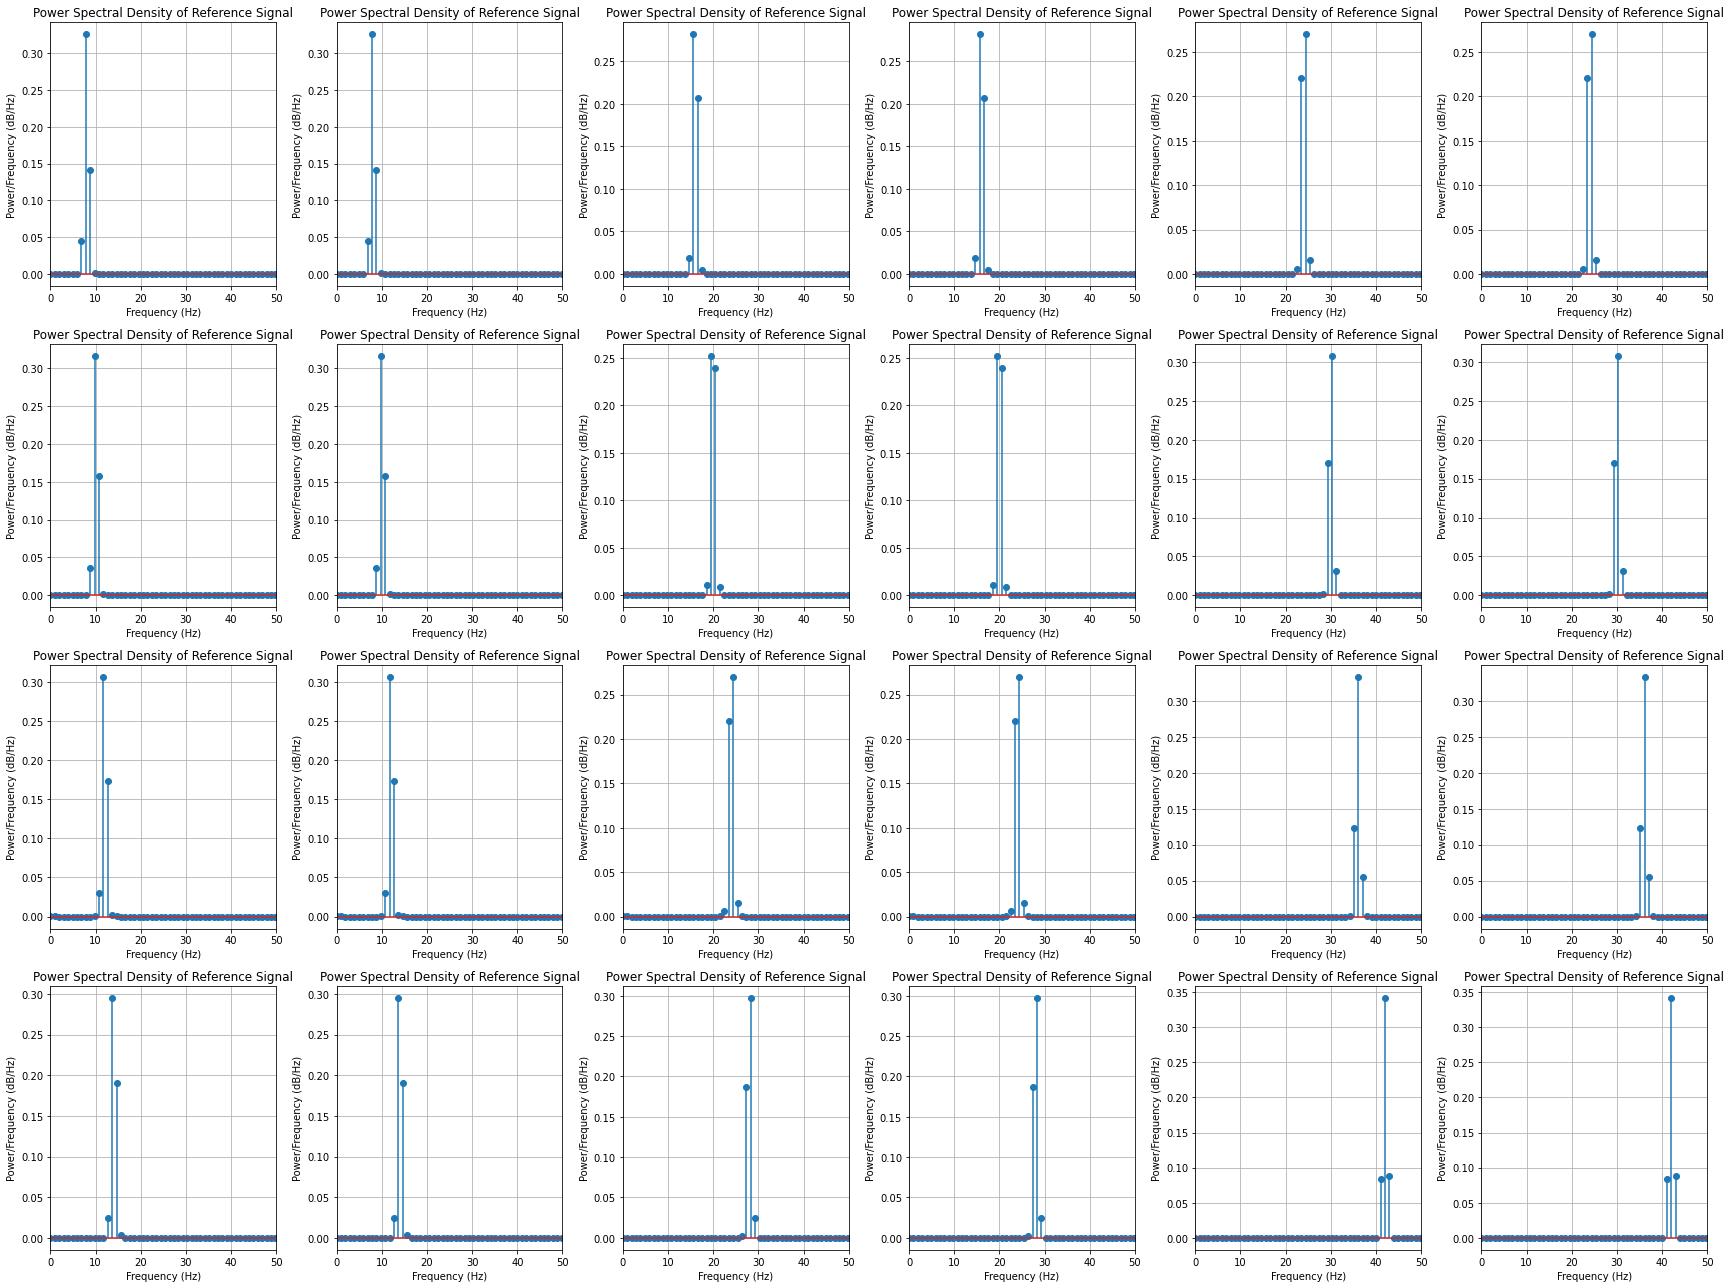

In [5]:
import core.utils2

importlib.reload(core.utils2)
from core.utils2 import generate_ref_signal


# get the ref signals
N = 1024
FS = 250
N_HARMONICS = 3
N_SUBBANDS = 6
FREQS = [8, 10, 12, 14]
LOWEST_FREQ = 2
UPMOST_FREQ = 54
W = 2.2

ref_signals = generate_ref_signal("./data/raw/Freq_Phase.mat", freqs=FREQS, N=N, n_harmonics=N_HARMONICS, fs=FS)

# np.save("./data/ref/ref_signals.npy", ref_signals)

# plot the ref signals
# fig, axs = plt.subplots(ref_signals.shape[1], ref_signals.shape[0], figsize=(24, 18))
# for i in range(ref_signals.shape[1]):
#     for j in range(ref_signals.shape[0]):
#         ref_signal = ref_signals[j, i]
#         axs[i, j].plot(ref_signal)
#         axs[i, j].set_xlabel("Frequency (Hz)")
#         axs[i, j].set_ylabel('Power/Frequency (dB/Hz)')
#         axs[i, j].set_title('Power Spectral Density of Reference Signal')
#         axs[i, j].grid('minor')
#         axs[i, j].set_xlim(0, 40)
# plt.tight_layout()
# plt.show()

# plot the psd of the ref signals
fig, axs = plt.subplots(ref_signals.shape[1], ref_signals.shape[0], figsize=(24, 18))
for i in range(ref_signals.shape[1]):
    for j in range(ref_signals.shape[0]):
        ref_signal = ref_signals[j, i]
        freqs, psd = signal.welch(ref_signal, fs=FS)
        axs[i, j].stem(freqs, psd, use_line_collection=True)
        axs[i, j].set_xlabel("Frequency (Hz)")
        axs[i, j].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i, j].set_title('Power Spectral Density of Reference Signal')
        axs[i, j].grid('minor')
        axs[i, j].set_xlim(0, 50)
plt.tight_layout()
plt.show()

In [6]:
# Now, for each subject and each target freq, calculate the accuracy
# each subject has its corresponding data in .data/final/{label} where label is the target freq [2, 4, 6, 8] --> 4 classes that corresponds to the target freqs
# the ref signals are the same for all subjects
# Use the fbcca function to calculate the accuracies: 
# fbcca(input_signal, Fs, n_subbands, filter_bank_design, ref_signals, lowest_freq, upmost_freq)
# input_signal: the EEG signal of the subject
# Fs: the sampling frequency (250)
# n_subbands: the number of subbands (3)
# filter_bank_design: the filter bank design (M1)
# ref_signals: the reference signals
# lowest_freq: the lowest freq of the filter bank (2)
# upmost_freq: the upmost freq of the filter bank (54)


def calculate_accuracies_for_each_subject(data_dir, idx_freqs, ref_signals):
    accuracies = np.empty((35, len(idx_freqs)))
    for i in range(1, 36):
        for freq in idx_freqs:
            actual_freq = idx_freqs.index(freq)
            label_dir = os.path.join(data_dir, str(freq))
            for j in range(0, 4):
                file_path = os.path.join(label_dir, "S" + str(i) + "_" + str(j) + ".npy")
                if os.path.exists(file_path):
                    segment = np.load(file_path).swapaxes(0, 1)
                    pred = fbcca(segment, FS, N_SUBBANDS, "M1", W, ref_signals, LOWEST_FREQ, UPMOST_FREQ)
                accuracies[i-1, actual_freq] = 1 if pred == actual_freq + 1 else 0
    return np.mean(accuracies, axis=1)
    

accuracies = calculate_accuracies_for_each_subject("./data/final", [0, 2, 4, 6], ref_signals)

In [7]:
accuracies

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.75,
       0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       0.75, 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  ,
       1.  , 1.  ])

In [54]:
# Get the subjects with the perfect accuracies
perfect_accuracies = np.where(accuracies == 1)[0]

# now we have the final data. next, we split it onto train and validation sets (each one in its directory, data/train,  data/val)
# we must only use the perfect_accurecies subjects for training/va;odatopm, and the rest for test
# we will use 84% of the data for training and 16% for validation
def split_data(src_dir, target_dir, split_ratio):
    labels = os.listdir(src_dir)
    for label in labels:
        label_dir = os.path.join(src_dir, label)
        files = os.listdir(label_dir)
        # Filter the files to only use the perfect accuracies
        files = [file for file in files if int(file.split("_")[0][1:]) in perfect_accuracies]
        print(files)
        random.shuffle(files)
        split_idx = int(len(files) * split_ratio)
        train_files = files[:split_idx]
        val_files = files[split_idx:]
        train_dir = os.path.join(target_dir, "train", label)
        val_dir = os.path.join(target_dir, "val", label)
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(val_dir):
            os.makedirs(val_dir)
        for file in train_files:
            shutil.copy(os.path.join(label_dir, file), os.path.join(train_dir, file))
        for file in val_files:
            shutil.copy(os.path.join(label_dir, file), os.path.join(val_dir, file))



split_data("./data/final", "./data", 0.85)

['S14_0.npy', 'S1_5.npy', 'S29_6.npy', 'S19_4.npy', 'S16_4.npy', 'S28_5.npy', 'S13_2.npy', 'S34_0.npy', 'S7_3.npy', 'S5_5.npy', 'S2_0.npy', 'S8_2.npy', 'S21_0.npy', 'S1_6.npy', 'S18_6.npy', 'S18_4.npy', 'S25_2.npy', 'S9_5.npy', 'S14_2.npy', 'S34_4.npy', 'S1_3.npy', 'S23_6.npy', 'S19_3.npy', 'S33_0.npy', 'S23_1.npy', 'S19_1.npy', 'S29_0.npy', 'S28_0.npy', 'S26_5.npy', 'S5_2.npy', 'S23_2.npy', 'S21_4.npy', 'S6_5.npy', 'S3_3.npy', 'S21_3.npy', 'S15_6.npy', 'S25_3.npy', 'S15_3.npy', 'S34_5.npy', 'S5_0.npy', 'S17_0.npy', 'S17_5.npy', 'S4_0.npy', 'S30_4.npy', 'S21_6.npy', 'S12_4.npy', 'S13_4.npy', 'S14_3.npy', 'S33_4.npy', 'S14_5.npy', 'S6_0.npy', 'S28_6.npy', 'S8_1.npy', 'S8_4.npy', 'S23_5.npy', 'S3_0.npy', 'S33_1.npy', 'S6_1.npy', 'S4_2.npy', 'S15_5.npy', 'S18_1.npy', 'S13_3.npy', 'S7_6.npy', 'S19_5.npy', 'S2_3.npy', 'S4_4.npy', 'S16_2.npy', 'S30_3.npy', 'S26_1.npy', 'S3_4.npy', 'S17_3.npy', 'S27_2.npy', 'S4_1.npy', 'S31_6.npy', 'S20_2.npy', 'S17_6.npy', 'S9_6.npy', 'S26_3.npy', 'S27_0.npy

In [55]:
# finally, rename the labels folders to 0, 1, 2 ... N instead of 2, 4, 6, 8
files = sorted(listdir("data/train/"))
print(files)
for file in files:
    shutil.move("data/train/" + file, "data/train/" + str(files.index(file)))
    shutil.move("data/val/" + file, "data/val/" + str(files.index(file)))
    

['0', '2', '4', '6']


[ 3.19270372 -3.70957375 -9.81682587 ...  3.84183073  0.475651
  0.70917666]


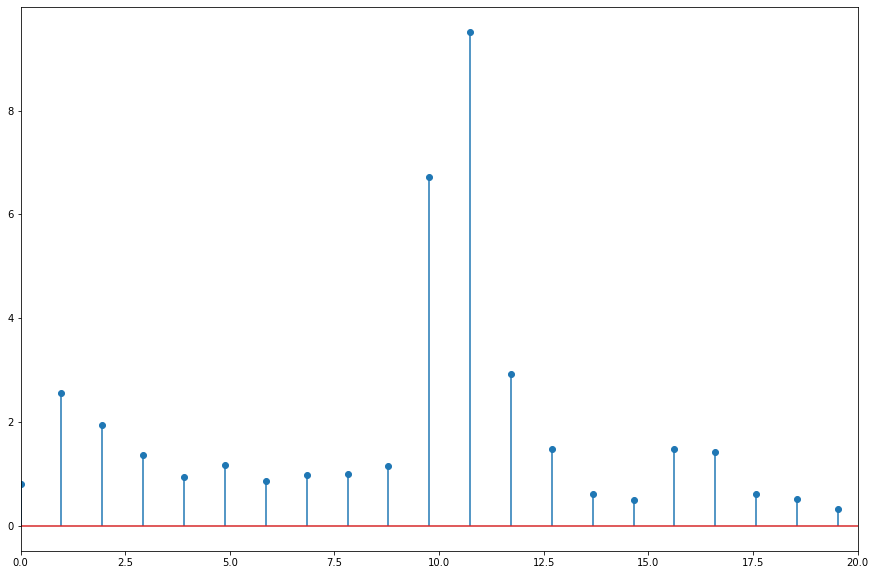

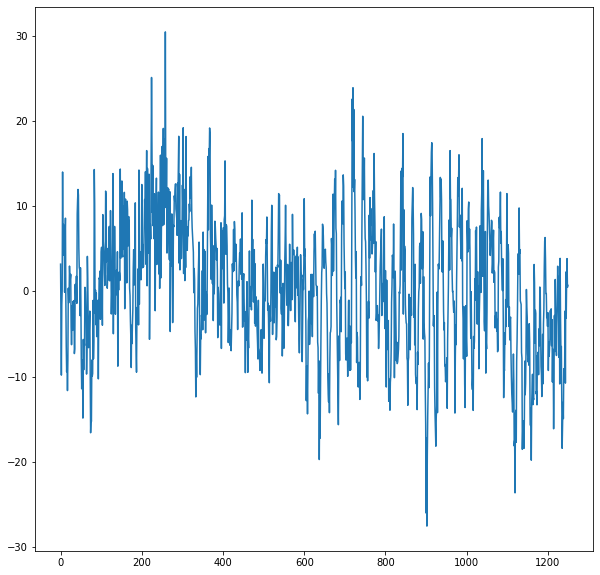

In [129]:
d_raw = read_mat_file("data/raw/S1.mat")['data'][-2, 125:(1250 + 125), 0, 1]# [0, 125:(1250 + 125), 0].shape
print(d_raw)
freqs, psd = signal.welch(d_raw, fs=250)
# plot the psd
plt.figure(figsize=(15,10))
plt.stem(freqs, psd, use_line_collection=True)
# the step on the X axis should be 0.25hz
# plt.xticks(np.arange(0, 20, 0.75))
plt.xlim(0, 20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(d_raw)
# plt.xlim(0, 50)
plt.show()


(30000, 4)


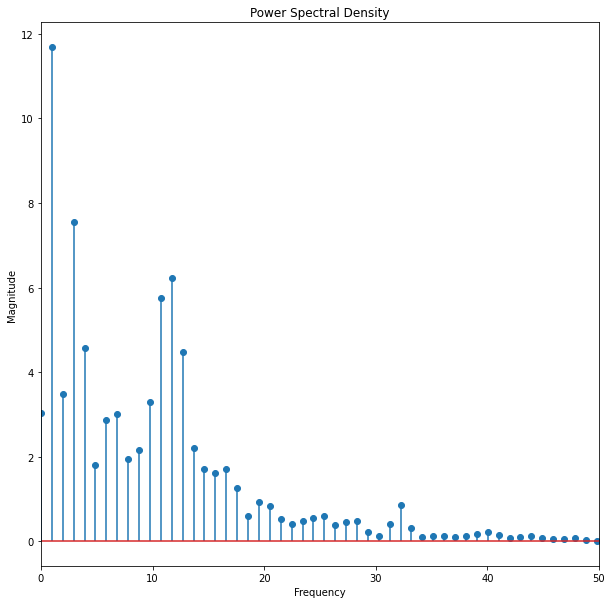

In [119]:
# data = np.load("./data/train/1/S2_4.npy")
data = pd.read_csv("./data/processed/S2.csv")
print(data.shape)

# data = data.swapaxes(0, 1)
data = data[data['labels'] == 0].to_numpy()
data = data[:, 0:3].swapaxes(0, 1)[:, 0:1024]

# get the first channel of the data
data = data[0, :]
# get the power spectral density of the data
freqs, psd = signal.welch(data, fs=250)
# plot the psd
plt.figure(figsize=(10,10))
plt.stem(freqs, psd, use_line_collection=True)
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 50)
plt.show()


In [58]:
# check  that all files inside ./data/ref/*/* has the same shape  (3, 1024)
files = glob.glob("./data/test/*/*")
for file in files:
    data = np.load(file)
    if data.shape != (3, 1024):
        print(file)
        print(data.shape)
        


(3, 1024)


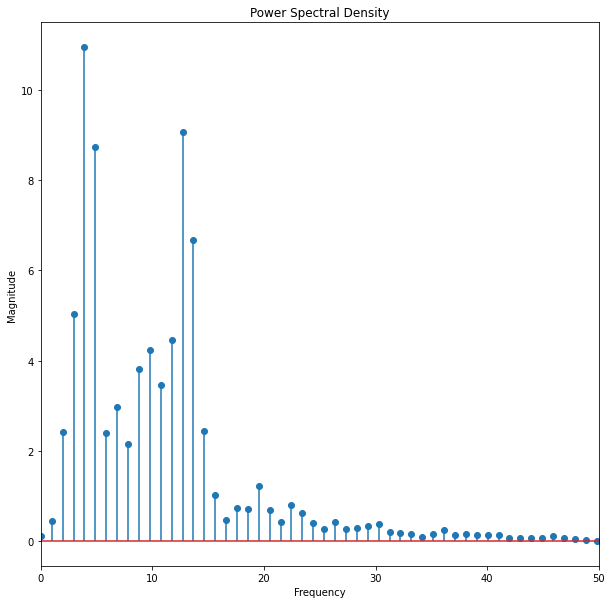

In [64]:
data = np.load("./data/train/1/S2_4.npy")
print(data.shape)
# get the first channel of the data
data = data[0, :]
# get the power spectral density of the data
freqs, psd = signal.welch(data, fs=250)
# plot the psd
plt.figure(figsize=(10,10))
plt.stem(freqs, psd, use_line_collection=True)
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 50)
plt.show()


In [283]:
np.load("./data/val/3/S4_0.npy").shape

(3, 1024)

(4, 3, 1024)


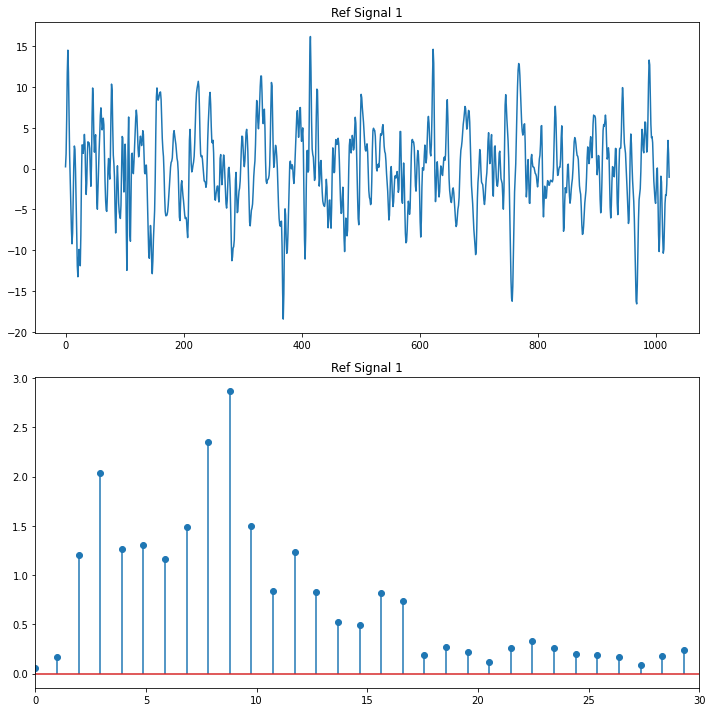

In [310]:
data = np.load('expr/results/ref_00_b.npy')
# data2 = np.load('data/ref/0/ref0.npy')
print(data.shape)
data = data[3, 0]
# print(data2)
# data2 = data2[0]
# plot the two ref signals together in order to see the difference
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(data)
axs[0].set_title('Ref Signal 1')
freqs, psd = signal.welch(data, fs=250)
axs[1].stem(freqs, psd, use_line_collection=True)
axs[1].set_title('Ref Signal 1')
# axs[1].xlim(0, 50) axes has no attribute xlim
axs[1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

# plot the psd of the two ref signals
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# axs[0].magnitude_spectrum(data, Fs=250)
# axs[0].set_title('Ref Signal 1')
# # axs[1].magnitude_spectrum(data2, Fs=250)
# # axs[1].set_title('Ref Signal 2')
# plt.tight_layout()
# plt.show()
